# Imports and data loading

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from torch.utils.data import DataLoader

import matplotlib
import matplotlib.pyplot as plt

import torch_loader
import preprocessing as pre
from importlib import reload

In [18]:
reload(pre)
reload(torch_loader)

# default prediction window = 60, sliding_window=30
ds = torch_loader.WebTrafficDataset('data', 'train_1')

series, target = ds[0]

Loading pickle...
Done!
For lag: 365 nan percent is 0.153
For lag: 91 nan percent is 0.038
Done loading and preprocessing set!


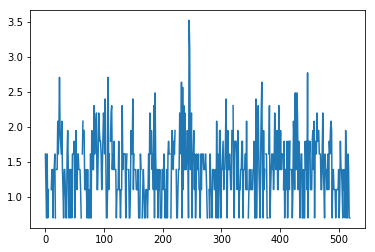

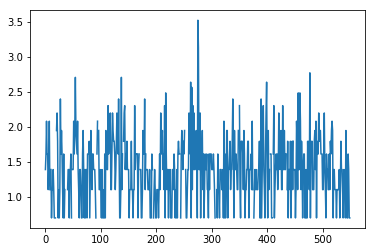

In [19]:
data = target
real = ds.get_series(0)

plt.plot(data)
plt.show()
plt.plot(real)
plt.show()

In [20]:
train_loader = DataLoader(ds,
                         batch_size=1,
                         shuffle=True,
                         num_workers=4)

for batch_idx, data in enumerate(train_loader):
    break

# Model Building

In [21]:
class Sequential(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, bias=True):
        super(Sequential, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.bias = bias
        
        self.gru1 = nn.GRUCell(self.input_size, self.hidden_size, bias=self.bias)
        self.gru2 = nn.GRUCell(self.hidden_size, self.hidden_size, bias=self.bias)
        self.linear = nn.Linear(self.hidden_size, self.input_size)
        
    def forward(self, input, future=0):
        hidden_t1 = Variable(torch.zeros(input.size(0), self.hidden_size).double(),
                            requires_grad=False)
        hidden_t2 = Variable(torch.zeros(input.size(0), self.hidden_size).double(),
                            requires_grad=False)
        
        outputs = []
        for i, input_t in enumerate(input.chunk(input.size(0), dim=1)):
            # input should be (seq_len, batch_size, input_size) for LSTM
            # (batch, input_size) for GRUCell
            hidden_t1 = self.gru1(input_t, hidden_t1)
            hidden_t2 = self.gru2(hidden_t1, hidden_t2)
            output = self.linear(hidden_t2)
            outputs += [output]
            
        for i in range(future):
            hidden_t1 = self.gru1(output, hidden_t1)
            hidden_t2 = self.gru2(hidden_t1, hidden_t2)
            output = self.linear(hidden_t2)
            outputs += [output]
            
        outputs = torch.stack(outputs, 1).squeeze(2)
        out = outputs[-1]
        return out
input_size = 1 # number of features. 1 for just tseries
hidden_size = 30
batch_size = 30

model = Sequential(input_size, hidden_size, batch_size)
model.double()
model

Sequential (
  (gru1): GRUCell(1, 30)
  (gru2): GRUCell(30, 30)
  (linear): Linear (30 -> 1)
)

In [28]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.2):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_first = False
        
        self.rnn = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=1,
            batch_first=False,
            dropout=dropout,
            bidirectional=False)
        self.fc1 = nn.Linear(self.hidden_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(self.hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        input_size = x.size(2)
        
        if ~(self.batch_first):
            x = x.view(seq_len, batch_size, input_size)
      
        h0 = Variable(torch.zeros(seq_len, batch_size, self.hidden_size).double())
        c0 = Variable(torch.zeros(seq_len, batch_size, self.hidden_size).double())
        
        out, (ht, ct) = self.rnn(x, (h0, c0))
        
        out = out[-1]
        out = self.fc1(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = F.dropout(out, training=self.training)
        out = self.fc2(out)
        return out
    
input_size = 19 # number of features. 1 for just tseries
hidden_size = 50
torch.manual_seed(1)
model = LSTM(input_size, hidden_size)
model.double()
model

LSTM (
  (rnn): LSTM(19, 50, dropout=0.2)
  (fc1): Linear (50 -> 50)
  (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True)
  (fc2): Linear (50 -> 1)
  (relu): ReLU ()
)

In [29]:
tseries, target = ds[123123]
print(tseries.shape)
tseries = Variable(torch.from_numpy(tseries))
target = Variable(torch.from_numpy(target))

out = model(tseries)
out

(408, 30, 19)


Variable containing:
1.00000e-03 *
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  7.7326
  

# Prediction with one wave

train with one wave a see if it generalizes well

In [352]:
input_size = 1 # number of features. 1 for just tseries
hidden_size = 50
model = LSTM(input_size, hidden_size)
model.double()

model.train()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=0.01)
running_loss = 0
losses = []
for i in range(30):
    input = Variable(torch.from_numpy(batches))
    label = Variable(torch.from_numpy(target))
    
    optimizer.zero_grad()
    out = model(input)
    loss = criterion(out, label)
    loss.backward()
    optimizer.step()
    
    losses += [loss.data[0]]
    running_loss += loss.data[0]
    
    #if i % 10 == 0:
        
    print('{:.3f}/{:.3f}'.format(loss.data[0], running_loss))
    
    

11.569/11.569
5.225/16.794
3.103/19.897
5.050/24.947
3.827/28.774
3.877/32.651
2.052/34.703
2.028/36.731
2.624/39.355
2.428/41.783
2.202/43.985
1.689/45.674
1.198/46.872
1.040/47.913
1.340/49.253
1.641/50.894
1.605/52.499
1.133/53.633
1.026/54.658
1.016/55.674
1.176/56.851
1.284/58.135
1.183/59.318
1.027/60.346
0.980/61.325
0.975/62.300
1.026/63.327
1.003/64.330
1.015/65.345
0.948/66.293


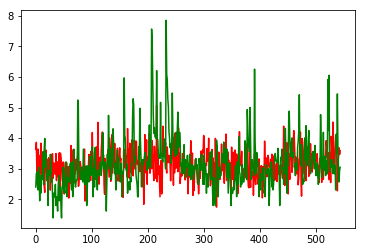

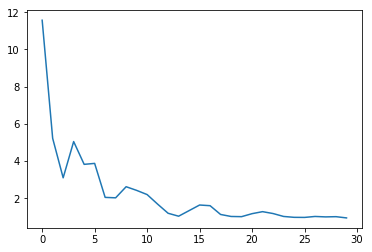

In [353]:
out = model(Variable(torch.from_numpy(batches)))
out = out.data.numpy().transpose().reshape(-1)
plt.plot(out, 'r', linewidth=1.5)
plt.plot(target, 'g', linewidth=1.5)

plt.show()

plt.plot(losses)
plt.show()


# Predictions with 1+ features

In [31]:
input, label = ds[0]
input = Variable(torch.from_numpy(input))
label = Variable(torch.from_numpy(label))

In [32]:
input_size = 19 # number of features. 1 for just tseries
hidden_size = 50
model = LSTM(input_size, hidden_size)
model.double()

model.train()


criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=0.01)
running_loss = 0
losses = []
for i in range(30):
    #input = Variable(torch.from_numpy(batches))
    #label = Variable(torch.from_numpy(target))
    
    optimizer.zero_grad()
    out = model(input)
    loss = criterion(out, label)
    loss.backward()
    optimizer.step()
    
    losses += [loss.data[0]]
    running_loss += loss.data[0]
    
    #if i % 10 == 0:
        
    print('{:.3f}/{:.3f}'.format(loss.data[0], running_loss))
    
    

nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan
nan/nan


# Training

In [ ]:
losses = []

def train(epoch):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.RMSprop(model.parameters(), lr=1e-3, 
                           weight_decay=1e-3, momentum=0.2)
    
    for batch_idx, data in enumerate(train_loader):
        tseries = data['tseries'].numpy().reshape(-1)
        (tseries, target) = pre.series_supervised_np(np.nan_to_num(tseries), 
                                                     lags=10, drop_nan=True)
        
        input = Variable(torch.from_numpy(tseries))
        target = Variable(torch.from_numpy(target))
        
        optimizer.zero_grad()
        output = model(input)
        
        loss = criterion(output, target)
        losses.append(loss)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
        if batch_idx == 10000:
            break

train(1)
losses

Train Epoch: 1 [0/145063 (0%)]	Loss: 1.844445
Train Epoch: 1 [10/145063 (0%)]	Loss: 12.832309
Train Epoch: 1 [20/145063 (0%)]	Loss: 1.017194
Train Epoch: 1 [30/145063 (0%)]	Loss: 13.301526
Train Epoch: 1 [40/145063 (0%)]	Loss: 0.769080
Train Epoch: 1 [50/145063 (0%)]	Loss: 9.796189
Train Epoch: 1 [60/145063 (0%)]	Loss: 1.587932
Train Epoch: 1 [70/145063 (0%)]	Loss: 0.846916
Train Epoch: 1 [80/145063 (0%)]	Loss: 7.098526
Train Epoch: 1 [90/145063 (0%)]	Loss: 0.723116
Train Epoch: 1 [100/145063 (0%)]	Loss: 7.783759
Train Epoch: 1 [110/145063 (0%)]	Loss: 1.550737
Train Epoch: 1 [120/145063 (0%)]	Loss: 6.247850
Train Epoch: 1 [130/145063 (0%)]	Loss: 6.351440
Train Epoch: 1 [140/145063 (0%)]	Loss: 4.385904
Train Epoch: 1 [150/145063 (0%)]	Loss: 6.422185
Train Epoch: 1 [160/145063 (0%)]	Loss: 10.031444
Train Epoch: 1 [170/145063 (0%)]	Loss: 9.267537
Train Epoch: 1 [180/145063 (0%)]	Loss: 2.392793
Train Epoch: 1 [190/145063 (0%)]	Loss: 2.063300
Train Epoch: 1 [200/145063 (0%)]	Loss: 1.402950


In [ ]:
# plot predictions

In [ ]:
# plot losses

In [ ]:
# plot learning curves

In [ ]:
# cross validation